# Phishing URL detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from urllib.parse import urlparse, parse_qs, quote
import time
from datetime import datetime
import whois
import requests
from bs4 import BeautifulSoup
from feature import FeatureExtraction

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import joblib

## Dataset

In [3]:
data = pd.read_csv('datasets/phishing-website-detector/phishing.csv')
data.head()

,Index,UsingIP,LongURL,ShortURL,Symbol@,Redirecting//,PrefixSuffix-,SubDomains,HTTPS,DomainRegLen,...,UsingPopupWindow,IframeRedirection,AgeofDomain,DNSRecording,WebsiteTraffic,PageRank,GoogleIndex,LinksPointingToPage,StatsReport,class
0,0,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
1,1,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
2,2,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
3,3,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1
4,4,-1,0,-1,1,-1,-1,1,1,-1,...,1,1,1,1,1,-1,1,-1,-1,1


In [4]:
data.shape

(11054, 32)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11054 entries, 0 to 11053
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Index                11054 non-null  int64
 1   UsingIP              11054 non-null  int64
 2   LongURL              11054 non-null  int64
 3   ShortURL             11054 non-null  int64
 4   Symbol@              11054 non-null  int64
 5   Redirecting//        11054 non-null  int64
 6   PrefixSuffix-        11054 non-null  int64
 7   SubDomains           11054 non-null  int64
 8   HTTPS                11054 non-null  int64
 9   DomainRegLen         11054 non-null  int64
 10  Favicon              11054 non-null  int64
 11  NonStdPort           11054 non-null  int64
 12  HTTPSDomainURL       11054 non-null  int64
 13  RequestURL           11054 non-null  int64
 14  AnchorURL            11054 non-null  int64
 15  LinksInScriptTags    11054 non-null  int64
 16  ServerFormHandler    1

In [6]:
data.nunique()

Index                  11054
UsingIP                    2
LongURL                    3
ShortURL                   2
Symbol@                    2
Redirecting//              2
PrefixSuffix-              2
SubDomains                 3
HTTPS                      3
DomainRegLen               2
Favicon                    2
NonStdPort                 2
HTTPSDomainURL             2
RequestURL                 2
AnchorURL                  3
LinksInScriptTags          3
ServerFormHandler          3
InfoEmail                  2
AbnormalURL                2
WebsiteForwarding          2
StatusBarCust              2
DisableRightClick          2
UsingPopupWindow           2
IframeRedirection          2
AgeofDomain                2
DNSRecording               2
WebsiteTraffic             3
PageRank                   2
GoogleIndex                2
LinksPointingToPage        3
StatsReport                2
class                      2
dtype: int64

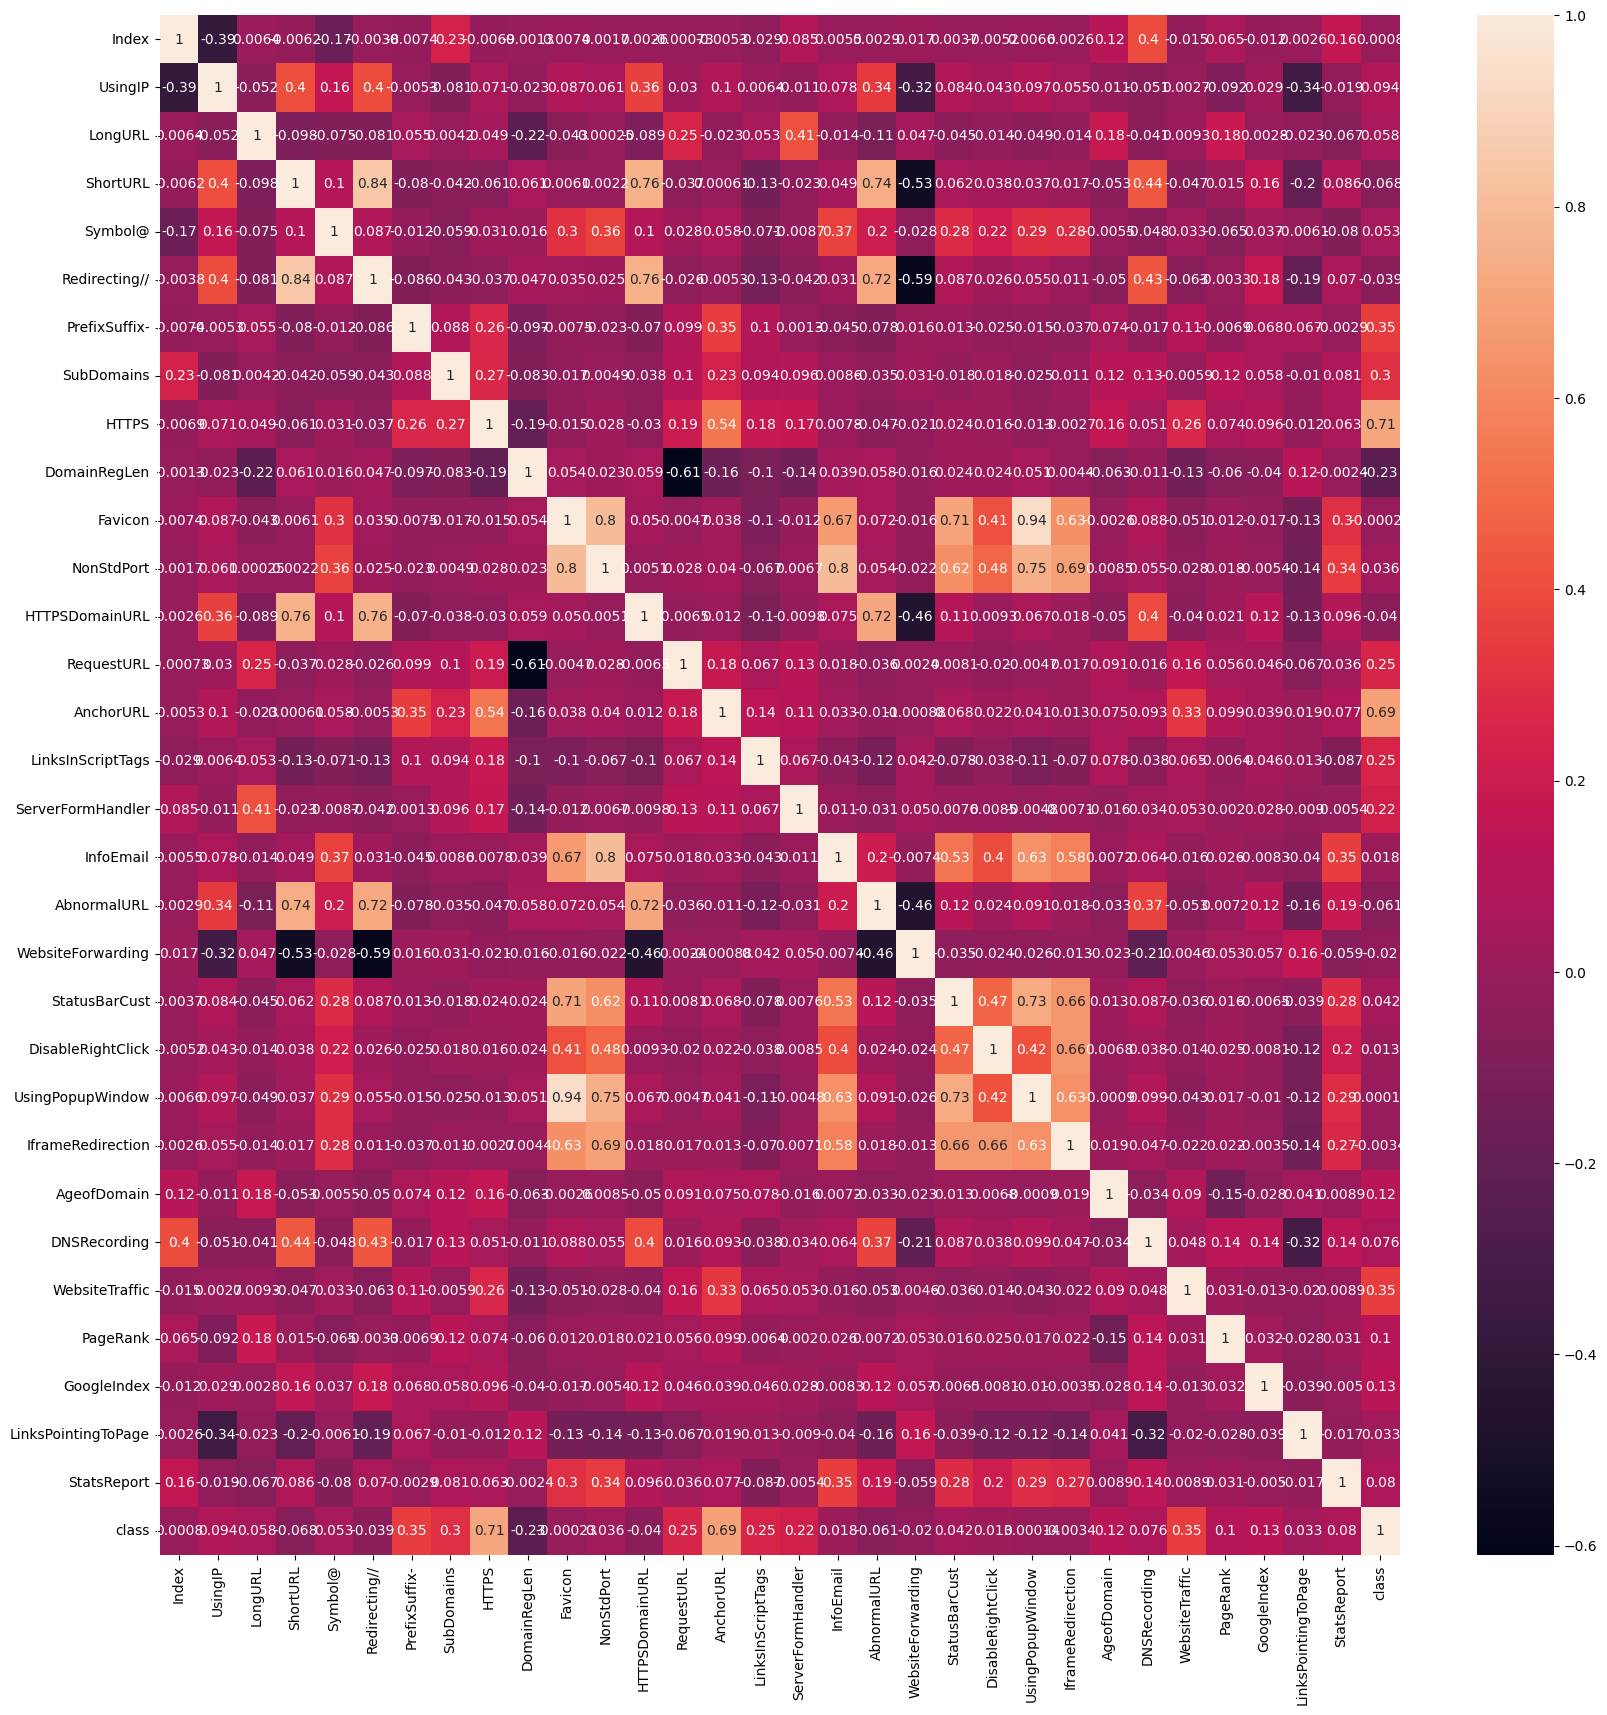

In [7]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot=True)
plt.show()

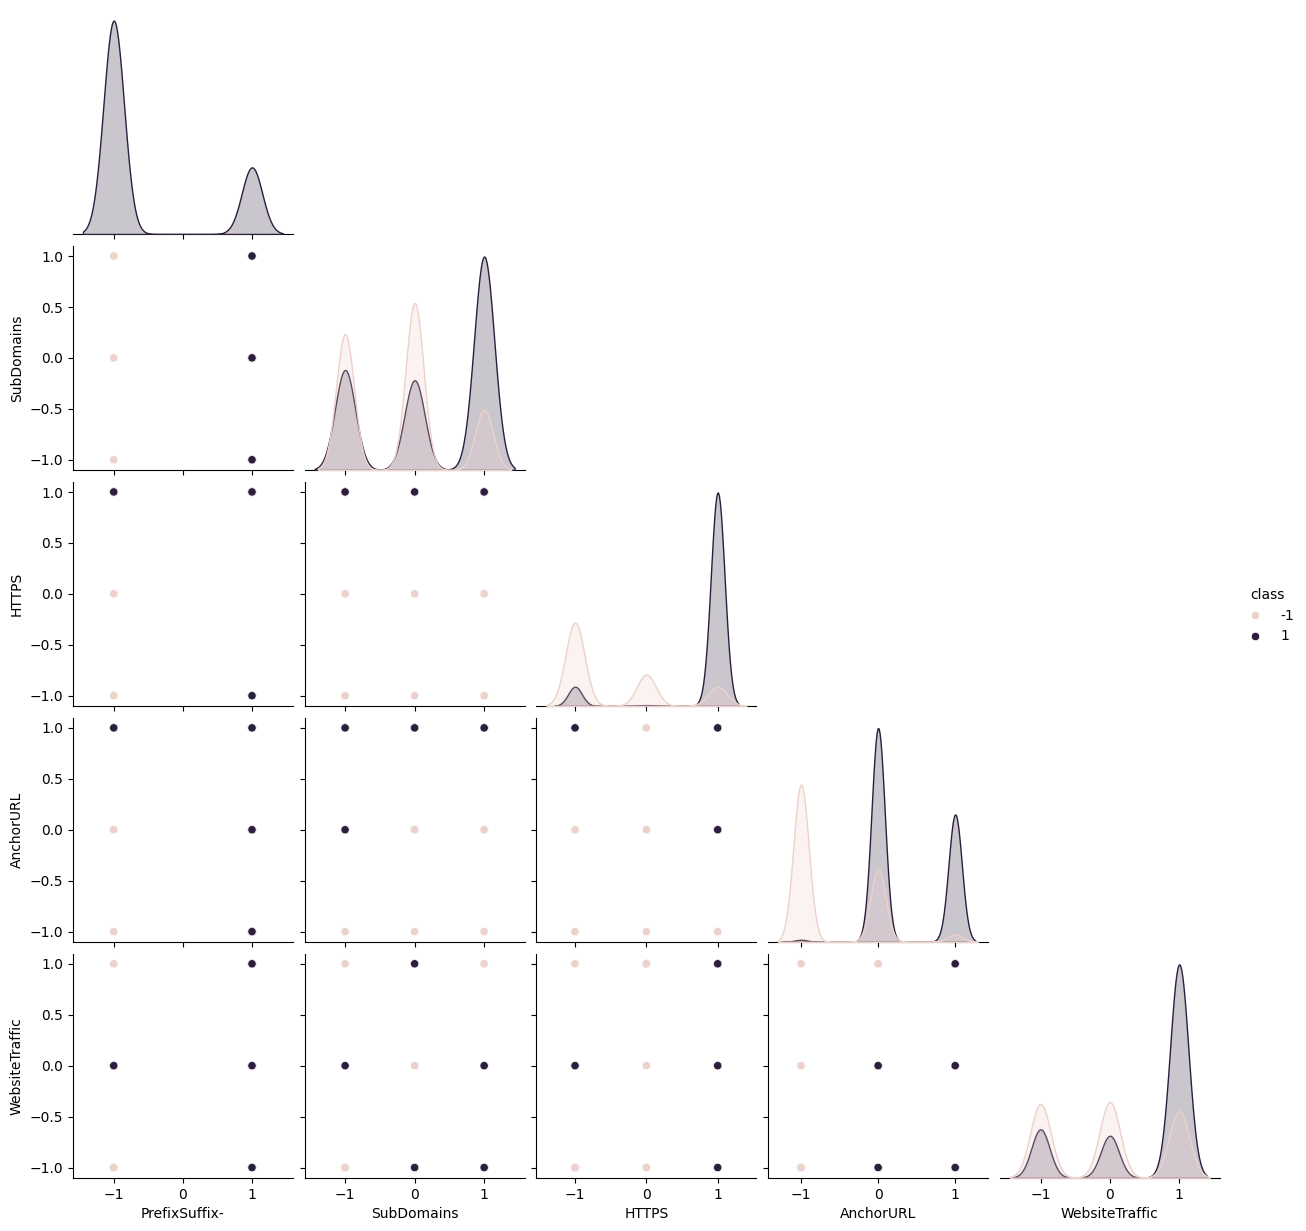

In [8]:
# Pairplot for Particular features
df = data[['PrefixSuffix-', 'SubDomains', 'HTTPS','AnchorURL','WebsiteTraffic','class']]
sns.pairplot(data = df, hue="class", corner=True);

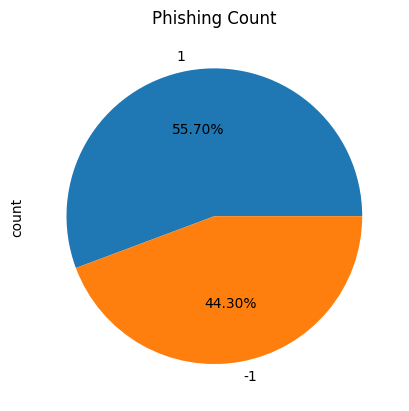

In [9]:
# Phishing Count in pie chart
data['class'].value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.title("Phishing Count")
plt.show()

## Train Test Split, Feature Scaling

In [10]:
# Splitting the dataset into dependant and independant fetature
X = data.drop(["class"],axis =1)
y = data["class"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8843, 31), (8843,), (2211, 31), (2211,))

## Model Training

In [12]:
# Instantiate the model
GBC = GradientBoostingClassifier(max_depth=4,learning_rate=0.7)

# Fit the model 
GBC.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.7, max_depth=4)

In [13]:
# Predicting the target value from the model for the samples
y_train_gbc = GBC.predict(X_train)
y_test_gbc = GBC.predict(X_test)

In [14]:
acc_train_gbc = metrics.accuracy_score(y_train,y_train_gbc)
acc_test_gbc = metrics.accuracy_score(y_test,y_test_gbc)
print("Gradient Boosting Classifier : Accuracy on training Data: {:.3f}".format(acc_train_gbc))
print("Gradient Boosting Classifier : Accuracy on test Data: {:.3f}".format(acc_test_gbc))
print()

f1_score_train_gbc = metrics.f1_score(y_train,y_train_gbc)
f1_score_test_gbc = metrics.f1_score(y_test,y_test_gbc)
print("Gradient Boosting Classifier : f1_score on training Data: {:.3f}".format(f1_score_train_gbc))
print("Gradient Boosting Classifier : f1_score on test Data: {:.3f}".format(f1_score_test_gbc))
print()

recall_score_train_gbc = metrics.recall_score(y_train,y_train_gbc)
recall_score_test_gbc =  metrics.recall_score(y_test,y_test_gbc)
print("Gradient Boosting Classifier : Recall on training Data: {:.3f}".format(recall_score_train_gbc))
print("Gradient Boosting Classifier : Recall on test Data: {:.3f}".format(recall_score_test_gbc))
print()

precision_score_train_gbc = metrics.precision_score(y_train,y_train_gbc)
precision_score_test_gbc = metrics.precision_score(y_test,y_test_gbc)
print("Gradient Boosting Classifier : precision on training Data: {:.3f}".format(precision_score_train_gbc))
print("Gradient Boosting Classifier : precision on test Data: {:.3f}".format(precision_score_test_gbc))

Gradient Boosting Classifier : Accuracy on training Data: 0.999
Gradient Boosting Classifier : Accuracy on test Data: 0.962

Gradient Boosting Classifier : f1_score on training Data: 0.999
Gradient Boosting Classifier : f1_score on test Data: 0.966

Gradient Boosting Classifier : Recall on training Data: 0.999
Gradient Boosting Classifier : Recall on test Data: 0.966

Gradient Boosting Classifier : precision on training Data: 0.999
Gradient Boosting Classifier : precision on test Data: 0.965


In [15]:
print(classification_report(y_test, y_test_gbc))

              precision    recall  f1-score   support

          -1       0.96      0.96      0.96       976
           1       0.97      0.97      0.97      1235

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211



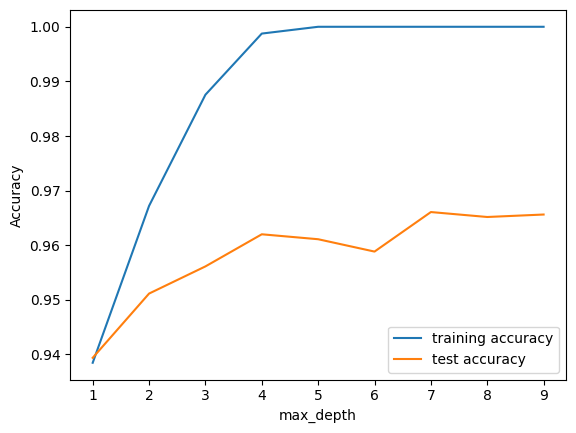

In [16]:
training_accuracy = []
test_accuracy = []
# try learning_rate from 0.1 to 0.9
depth = range(1,10,1)
for n in depth:
    gbc_test =  GradientBoostingClassifier(max_depth = n,learning_rate = 0.7)

    gbc_test.fit(X_train, y_train)
    # Record training set accuracy
    training_accuracy.append(gbc_test.score(X_train, y_train))
    # Record generalization accuracy
    test_accuracy.append(gbc_test.score(X_test, y_test))
    

#plotting the training & testing accuracy for n_estimators from 1 to 50
plt.figure(figsize=None)
plt.plot(depth, training_accuracy, label="training accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")  
plt.xlabel("max_depth")
plt.legend()

In [17]:
joblib.dump(GBC, 'phishing_url_model.joblib')

['phishing_url_model.joblib']

## Model Testing

In [18]:
def test_model(url):
    obj = FeatureExtraction(url)
    x = np.array(obj.getFeaturesList()).reshape(1, 30)
    y_pred = GBC.predict(x)[0]
    # 1 is legitimate, -1 is phishing
    y_pro_phishing = GBC.predict_proba(x)[0,0]
    y_pro_non_phishing = GBC.predict_proba(x)[0,1]
    pred = "It is {0:.2f} safe to go ".format(y_pro_phishing*100)
    xx = round(y_pro_non_phishing, 2)
    print(xx)
    return str(round(y_pro_non_phishing, 2))

In [ ]:
test_model('https://pypi.org/project/googlesearch-python/')

In [ ]:
def count_hyperlinks(url):
    try:
        # Step 2: Fetch the webpage
        response = requests.get(url)
        
        # Check for successful request
        if response.status_code != 200:
            print(f"Failed to retrieve webpage: Status code {response.status_code}")
            return 0
        
        # Step 3: Parse HTML content
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Step 4: Extract all <a> tags
        links = soup.find_all('a')
        
        # Step 5: Return the count of hyperlinks
        return len(links)
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return 0

In [ ]:
def link_ratio(url):
    try:
        # Fetch the webpage
        response = requests.get(url)
        
        # Check for successful request
        if response.status_code != 200:
            print(f"Failed to retrieve webpage: Status code {response.status_code}")
            return None
        
        # Parse HTML content
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract all <a> tags
        links = soup.find_all('a')
        
        # Initialize counters
        internal_count = 0
        external_count = 0
        
        # Get the base domain of the URL
        base_domain = urlparse(url).netloc
        
        # Classify links as internal or external
        for link in links:
            href = link.get('href')
            if href:
                parsed_href = urlparse(href)
                # Check if it's an internal link
                if parsed_href.netloc == base_domain or not parsed_href.netloc:
                    internal_count += 1
                else:
                    external_count += 1
        
        # Calculate ratio
        total_links = internal_count + external_count
        if total_links == 0:
            return (0, 0)  # Avoid division by zero
        
        ratio = internal_count / external_count if external_count > 0 else float('inf')
        
        return ratio
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [ ]:
def has_empty_title(url):
    try:
        # Step 2: Fetch the webpage
        response = requests.get(url)
        
        # Check for successful request
        if response.status_code != 200:
            print(f"Failed to retrieve webpage: Status code {response.status_code}")
            return False
        
        # Step 3: Parse HTML content
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Step 4: Extract title
        title = soup.title.string if soup.title else None
        
        # Check if title is empty or None
        if title is None or title.strip() == "":
            return 1  # Title is empty
        
        return 0  # Title is not empty
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

In [ ]:
def title_contains_domain(url):
    try:
        # Step 1: Fetch the webpage
        response = requests.get(url)
        
        # Check for successful request
        if response.status_code != 200:
            print(f"Failed to retrieve webpage: Status code {response.status_code}")
            return False
        
        # Step 2: Parse HTML content
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract title
        title = soup.title.string if soup.title else ""
        
        # Step 3: Get the domain from the URL
        domain = urlparse(url).netloc
        
        # Check if the domain is in the title (case insensitive)
        if domain.lower() in title.lower():
            return 0
        
        return 1
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

In [ ]:
def get_domain_age(url):
    try:
        # Step 2: Extract domain from URL
        domain_name = urlparse(url).netloc
        
        # Step 3: Query WHOIS information for the domain
        domain_info = whois.whois(domain_name)
        
        # Extract creation date
        creation_date = domain_info.creation_date
        
        # Handle cases where creation_date is a list (some domains may have multiple creation dates)
        if isinstance(creation_date, list):
            creation_date = creation_date[0]  # Take the first date if multiple
        
        # Step 4: Calculate age of the domain
        if isinstance(creation_date, datetime):
            today = datetime.now()
            age = today - creation_date
            return age.days  # Return age in days
        else:
            print("Creation date is not valid.")
            return None
            
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [ ]:
def check_indexing_with_site_command(url):
    query = f"site:{url}"
    response = requests.get(f"https://www.google.com/search?q={quote(query)}")
    
    # Check if the response contains any results
    if "did not match any documents" in response.text:
        return 0  # Not indexed
    else:
        return 1  # Indexed

In [ ]:
api_key = 'wgk8sgo0ckkcgw84kw8w4w0w4gwc00cgk08kk4s0'

In [ ]:
def get_page_rank(url, api_key):
    # Extract the domain from the URL
    domain = url.split("//")[-1].split("/")[0]  # Get domain part
    
    # Define the API endpoint
    api_url = "https://openpagerank.com/api/v1.0/getPageRank"
    
    # Set up headers with your API key
    headers = {
        "API-OPR": api_key
    }
    
    # Prepare parameters for the request
    params = {
        "domains[]": domain  # Send the domain as a parameter
    }
    
    # Make the GET request to the Open PageRank API
    response = requests.get(api_url, headers=headers, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        if data['response']:
            page_rank_info = data['response'][0]
            return page_rank_info['page_rank_integer']
        else:
            return None  # No data found for this domain
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

In [ ]:
def extract_url_features(url, api_key):
    parsed_url = urlparse(url)
    
    # Extracting features
    features = {
        'length_url': len(url),
        'length_hostname': len(parsed_url.hostname) if parsed_url.hostname else 0,
        'ip': None,  # Placeholder for IP resolution (requires additional implementation)
        'nb_dots': url.count('.'),
        'nb_qm': url.count('?'),
        'nb_eq': url.count('='),
        'nb_slash': url.count('/'),
        'nb_www': url.count('www.'),
        'ratio_digits_url': sum(c.isdigit() for c in url) / len(url) if len(url) > 0 else 0,
        'ratio_digits_host': sum(c.isdigit() for c in parsed_url.hostname) / len(parsed_url.hostname) if parsed_url.hostname else 0,
        'tld_in_subdomain': 1 if parsed_url.hostname and re.search(r'\.[a-z]{2,}$', parsed_url.hostname) else 0,
        'prefix_suffix': 1 if (parsed_url.path.startswith('/') or parsed_url.path.endswith('.html')) else 0,
        'shortest_word_host': min(len(word) for word in parsed_url.hostname.split('.') if word) if parsed_url.hostname else 0,
        'longest_words_raw': max((len(word) for word in parsed_url.path.split('/') if word), default=0),
        'longest_word_path': max((len(word) for word in parsed_url.path.split('/') if word), default=0),
        'phish_hints': 0,  # Placeholder for phishing detection logic
        'nb_hyperlinks': count_hyperlinks(url),  # Requires HTML parsing (additional implementation needed)
        'ratio_intHyperlinks': link_ratio(url),  # Requires HTML parsing (additional implementation needed)
        'empty_title': has_empty_title(url),  # Requires HTML fetching (additional implementation needed)
        'domain_in_title': title_contains_domain(url),  # Requires HTML fetching (additional implementation needed)
        'domain_age': get_domain_age(url),  # Requires domain registration lookup (additional implementation needed)
        'google_index': check_indexing_with_site_command(url),  # Requires Google search API check (additional implementation needed)
        'page_rank': get_page_rank(url, api_key)   # Requires external service/API to get page rank
    }
    
    return features

In [ ]:
extract_url_features(url='http://www.enkiquotes.com/', api_key=api_key)

In [ ]:
test_url = 'https://www.lukeptaylor.com/blog/sigma-fp-a-tiny-full-frame-photography-powerhouse'
test_url_1='http://vamoaestudiarmedicina.blogspot.com/'

In [ ]:
features_dict = extract_url_features(test_url, api_key)
features_df = pd.DataFrame([features_dict])
features_df = features_df[selected_features]
features_scaled = scaler.transform(features_df)

prediction = model.predict(features_scaled)

# Output the result
result = 'phishing' if prediction[0] == 1 else 'legitimate'
print(f'The URL "{test_url}" is classified as: {result}')

In [ ]:
prediction